## Import Libraries

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# processing libraries 
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, chi2

# model libraries 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.model_selection import train_test_split
from sklearn import metrics 

## Import Dataset

In [2]:
df = pd.read_csv('Churners.csv')
df = df.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', axis = 1)
df = df.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', axis = 1)

In [3]:
df.head(4).style.set_properties(**{"background-color": "#b2c4cc","color": "black", "border-color": "black", "font-size":"8pt", 'width': 200})

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.000000,777,11914.000000,1.335000,1144,42,1.625000,0.061000
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.000000,864,7392.000000,1.541000,1291,33,3.714000,0.105000
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.000000,0,3418.000000,2.594000,1887,20,2.333000,0.000000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.000000,2517,796.000000,1.405000,1171,20,2.333000,0.760000


In [4]:
df.describe().style.set_properties(**{"background-color": "#b2c4cc","color": "black", "border-color": "black", "font-size":"8pt", 'width': 200})

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,739177606.333663,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,36903783.450231,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,708082083.000000,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,713036770.500000,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,717926358.000000,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,773143533.000000,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,828343083.000000,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [5]:
# number of churn and non-churn 
counts = df.Attrition_Flag.value_counts()
perc_churn = (counts[1] / (counts[0] + counts[1])) * 100

# no. of duplicates 
duplicates = len(df[df.duplicated()])

# no of missing values
missing_values = df.isnull().sum().sum()

# Data types in dataset
types = df.dtypes.value_counts()

In [6]:
print("Churn Rate = %.1f %%"%(perc_churn))
print('Number of Duplicate Entries: %d'%(duplicates))
print('Number of Missing Values: %d'%(missing_values))
print('Number of Features: %d'%(df.shape[1]))
print('Number of Customers: %d'%(df.shape[0]))
print('Data Types and Frequency in Dataset:')
print(types)

Churn Rate = 16.1 %
Number of Duplicate Entries: 0
Number of Missing Values: 0
Number of Features: 21
Number of Customers: 10127
Data Types and Frequency in Dataset:
int64      10
object      6
float64     5
dtype: int64


## Visualisations

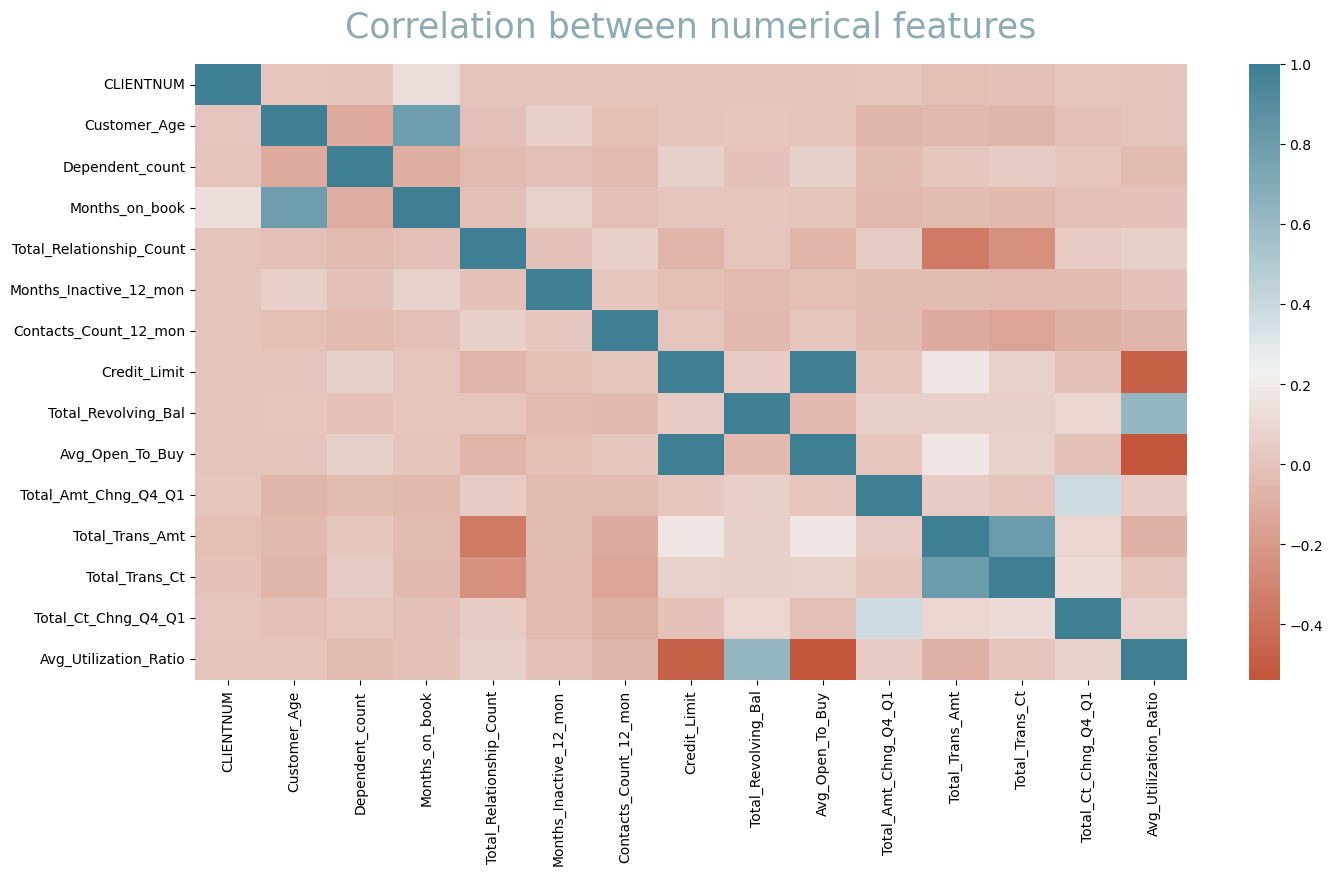

In [7]:
#Code adapted from https://www.kaggle.com/code/winternguyen/churning-customers-98-95-detected#Step-2.-Exploratory-data-analysis

heat = df.corr()
plt.figure(figsize = [16,8])
plt.title("Correlation between numerical features", size = 25, pad = 20, color = '#8cabb6')
sns.heatmap(heat, cmap = sns.diverging_palette(20, 220, n = 200), annot = False)
plt.show()

<div class="alert alert-block alert-info">
<b>Key Point:</b> 'Avg_open_to_buy' and 'Credit_Limit' are highly correlated.
</div>

<div class="alert alert-block alert-info">
<b>Key Point:</b> 'Total_Trans_Amt' and 'Total_Trans_Ct' are closely correlated.
</div>

<div class="alert alert-block alert-info">
<b>Key Point:</b> 'Total_Revolving_Bal', 'Credit_Limit' and 'Avg_open_to_buy' all seem to be connect to the 'Avg_Utilization_Ratio'.
</div>

Text(0, 0.5, 'Income_Category')

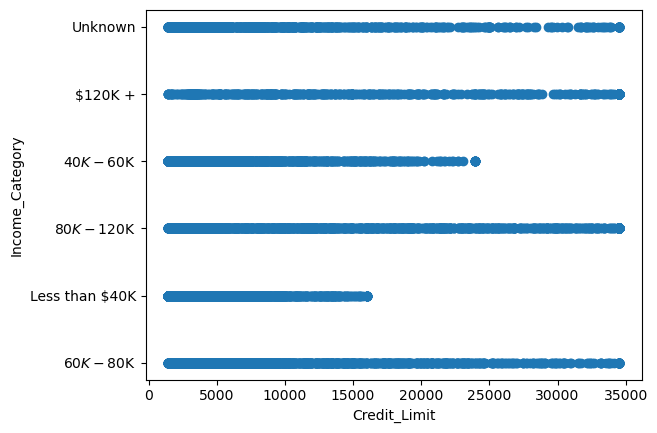

In [8]:
# exploring the features that could be connect to credit limit
plt.scatter(df['Credit_Limit'], df['Income_Category'])
plt.xlabel('Credit_Limit')
plt.ylabel('Income_Category') 

Text(0, 0.5, 'Card_Category')

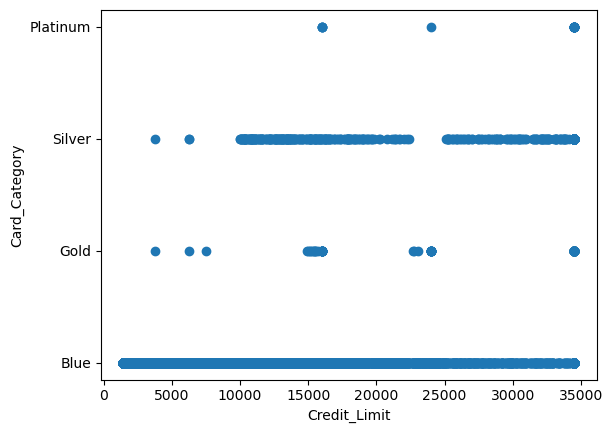

In [9]:
plt.scatter(df['Credit_Limit'], df['Card_Category'])
plt.xlabel('Credit_Limit')
plt.ylabel('Card_Category') 

Text(0, 0.5, 'Avg_Open_To_Buy')

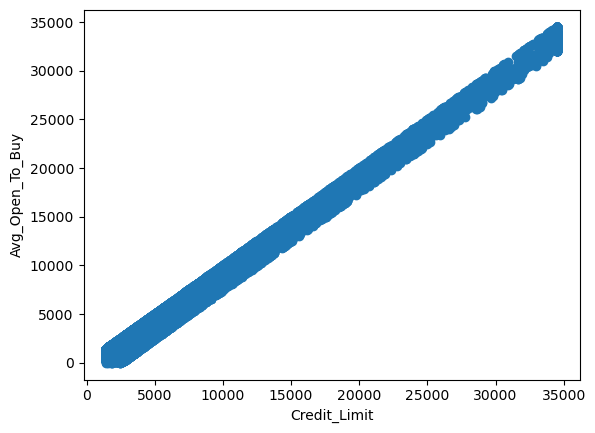

In [10]:
plt.scatter(df['Credit_Limit'], df['Avg_Open_To_Buy'])
plt.xlabel('Credit_Limit')
plt.ylabel('Avg_Open_To_Buy') 

Text(0, 0.5, 'Avg_Utilization_Ratio')

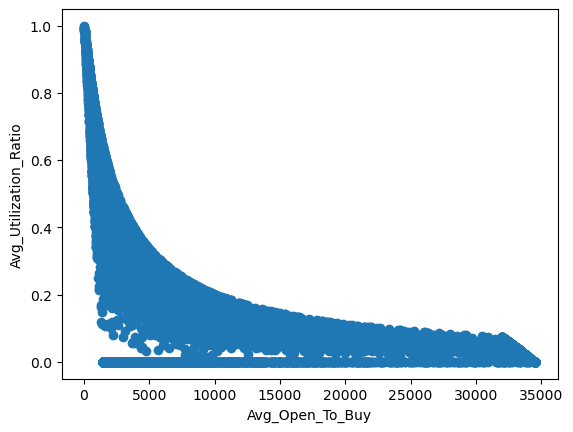

In [11]:
# exploring the connection to avg utilisation ratio
plt.scatter(df['Avg_Open_To_Buy'], df['Avg_Utilization_Ratio'])
plt.xlabel('Avg_Open_To_Buy')
plt.ylabel('Avg_Utilization_Ratio') 

Text(0, 0.5, 'Avg_Utilization_Ratio')

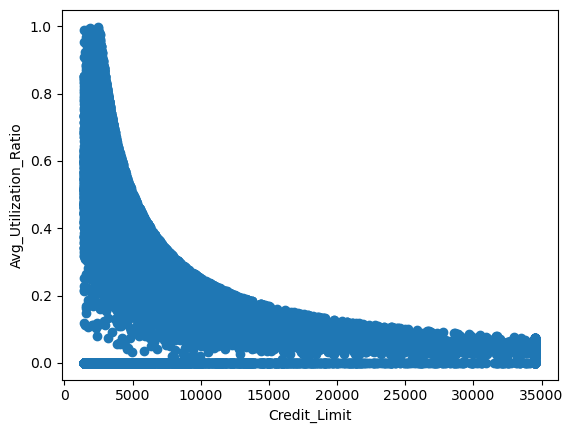

In [12]:
plt.scatter(df['Credit_Limit'], df['Avg_Utilization_Ratio'])
plt.xlabel('Credit_Limit')
plt.ylabel('Avg_Utilization_Ratio') 

Text(0, 0.5, 'Avg_Utilization_Ratio')

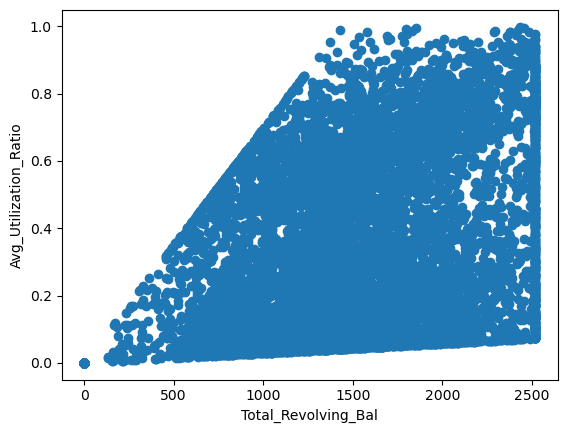

In [13]:
plt.scatter(df['Total_Revolving_Bal'], df['Avg_Utilization_Ratio'])
plt.xlabel('Total_Revolving_Bal')
plt.ylabel('Avg_Utilization_Ratio') 

Text(0, 0.5, 'Total_Trans_Ct')

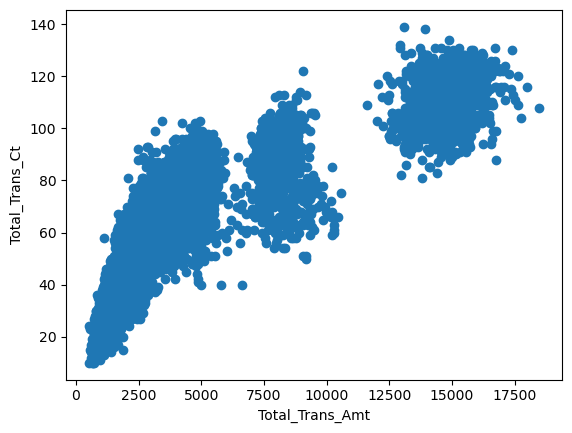

In [14]:
# is the total transaction amount connected to the total transaction count
plt.scatter(df['Total_Trans_Amt'], df['Total_Trans_Ct'])
plt.xlabel('Total_Trans_Amt')
plt.ylabel('Total_Trans_Ct') 

<div class="alert alert-block alert-info">
<b>Example:</b> One of Credit limit or avg open to buy need to be removed as they are highly correlated with each other. They both also correlate with income and avg utilisation ratio suggesting they are connected to each other. 
</div>

## Pre-Processing

In [15]:
# make gender and outcome numerical
df['Gender'] = df['Gender'].map({'M': 1, 'F': 0})
df['Attrition_Flag'] = df['Attrition_Flag'].map({'Attrited Customer': 1, 'Existing Customer': 0})

# drop client id
df = df.drop('CLIENTNUM', axis = 1)

# Code adapted from: https://www.kaggle.com/code/andreshg/churn-prediction-0-99-auc-h2o-sklearn-smote#2.-Feature-Engeneering
catcols = df.select_dtypes(exclude = ['int64','float64']).columns
intcols = df.select_dtypes(include = ['int64']).columns
floatcols = df.select_dtypes(include = ['Float64']).columns

# one-hot encoding on categorical columns
df = pd.get_dummies(df, columns = catcols)

# minmax scaling numeric features 
for col in df[floatcols]:
    df[col] = MinMaxScaler().fit_transform(df[[col]])
    
for col in df[intcols]:
    df[col] = MinMaxScaler().fit_transform(df[[col]])
    
print('New Number of Features: %d'%(df.shape[1]))  

New Number of Features: 37


In [16]:
# split into X and y
X = df.drop('Attrition_Flag', axis = 1)
y = df['Attrition_Flag']

In [17]:
display(X)

,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0.404255,1.0,0.6,0.604651,0.8,0.166667,0.500000,0.340190,0.308701,0.345116,...,0,0,1,0,0,0,1,0,0,0
1,0.489362,0.0,1.0,0.720930,1.0,0.166667,0.333333,0.206112,0.343266,0.214093,...,0,0,0,0,1,0,1,0,0,0
2,0.531915,1.0,0.6,0.534884,0.6,0.166667,0.000000,0.059850,0.000000,0.098948,...,0,0,0,1,0,0,1,0,0,0
3,0.297872,0.0,0.8,0.488372,0.4,0.666667,0.166667,0.056676,1.000000,0.022977,...,0,0,0,0,1,0,1,0,0,0
4,0.297872,1.0,0.6,0.186047,0.8,0.166667,0.000000,0.099091,0.000000,0.136557,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0.510638,1.0,0.4,0.627907,0.4,0.333333,0.500000,0.077536,0.735399,0.062266,...,0,1,0,0,0,0,1,0,0,0
10123,0.319149,1.0,0.4,0.279070,0.6,0.333333,0.500000,0.085819,0.868494,0.060499,...,0,1,0,0,0,0,1,0,0,0
10124,0.382979,0.0,0.2,0.534884,0.8,0.500000,0.666667,0.120042,0.000000,0.156637,...,0,0,0,0,1,0,1,0,0,0
10125,0.085106,1.0,0.4,0.534884,0.6,0.500000,0.500000,0.116172,0.000000,0.152928,...,0,1,0,0,0,0,1,0,0,0


## Feature Selection

### Correlation Coefficients Ranking

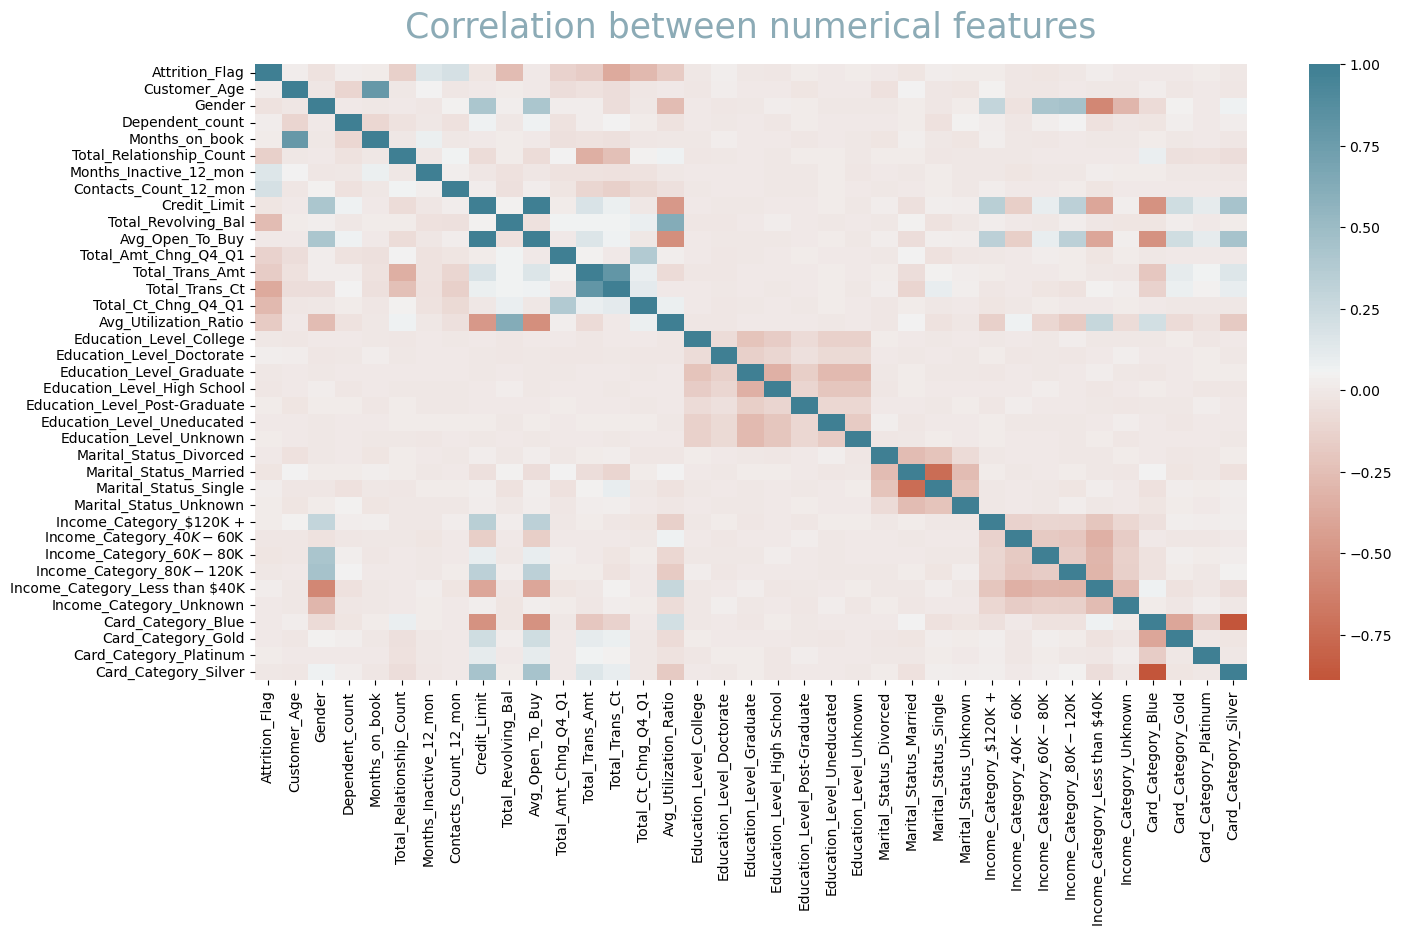

In [18]:
heat = df.corr()
plt.figure(figsize=[16,8])
plt.title("Correlation between numerical features", size = 25, pad = 20, color = '#8cabb6')
sns.heatmap(heat,cmap = sns.diverging_palette(20, 220, n = 200), annot=False)
plt.show()

In [19]:
# Code adapted from: https://www.kaggle.com/code/winternguyen/churning-customers-98-95-detected#Step-4:-Feature-Selection

print("Correlation Coefficient of all the Features")
corr = df.corr()
corr.sort_values(["Attrition_Flag"], ascending = False, inplace = True)
correlations = corr.Attrition_Flag
a = correlations[correlations > 0.1]
b = correlations[correlations < -0.1]
top_corr_features = a.append(b)
top_corr_features

Correlation Coefficient of all the Features


Attrition_Flag              1.000000
Contacts_Count_12_mon       0.204491
Months_Inactive_12_mon      0.152449
Total_Amt_Chng_Q4_Q1       -0.131063
Total_Relationship_Count   -0.150005
Total_Trans_Amt            -0.168598
Avg_Utilization_Ratio      -0.178410
Total_Revolving_Bal        -0.263053
Total_Ct_Chng_Q4_Q1        -0.290054
Total_Trans_Ct             -0.371403
Name: Attrition_Flag, dtype: float64

### Look at the best performing features in 3 ensemble models

In [20]:

def plot_importances(model, model_name, features_to_plot, feature_names):
    #fit model and performances
    model.fit(X,y)
    importances = model.feature_importances_
    
    # sort and rank importances
    indices = np.argsort(importances)
    best_features = np.array(feature_names)[indices][-features_to_plot:]
    values = importances[indices][-features_to_plot:]
    
    # plot a graph
    y_ticks = np.arange(0, features_to_plot)
    fig, ax = plt.subplots()
    ax.barh(y_ticks, values, color = '#b2c4cc')
    ax.set_yticklabels(best_features)
    ax.set_yticks(y_ticks)
    ax.set_title("%s Feature Importances"%(model_name))
    fig.tight_layout()
    plt.show()
    
def best_features(model, features_to_plot, feature_names):
    # get list of best features 
    model.fit(X,y)
    importances = model.feature_importances_

    indices = np.argsort(importances)
    best_features = np.array(feature_names)[indices][-features_to_plot:]
    return best_features

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


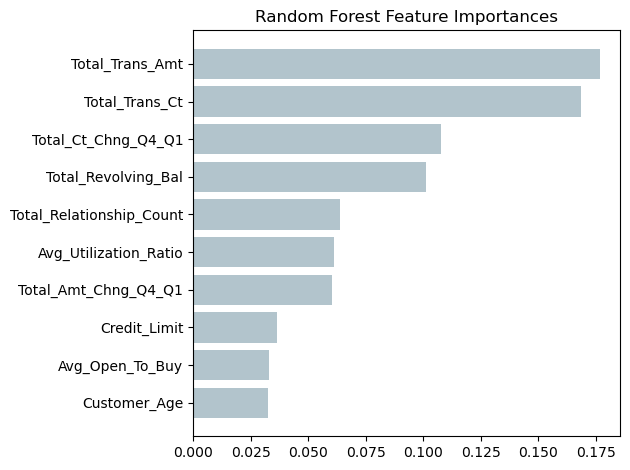

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


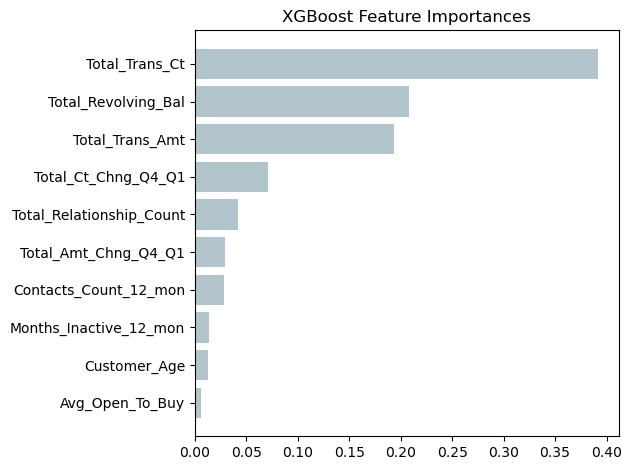

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


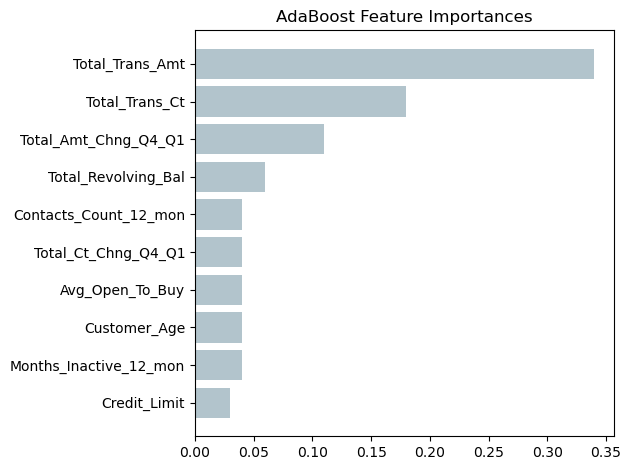

In [21]:
feature_names = list(X.columns)

model1 = RandomForestClassifier(random_state = 1234)
plot_importances(model1, 'Random Forest', 10, feature_names)

model2 = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1, random_state = 0)
plot_importances(model2, 'XGBoost', 10, feature_names)

model3 = AdaBoostClassifier(n_estimators = 100, learning_rate = 1.0, random_state = 0)
plot_importances(model3, 'AdaBoost', 10, feature_names)

### Using selectkbest to find the best parameters

In [22]:
# looking at the F-value between label/feature for classification tasks
f_selector = SelectKBest(f_classif, k = 10)
f_selector.fit_transform(X, y)
f_selector_best = f_selector.get_feature_names_out()
print(f_selector_best)

['Gender' 'Total_Relationship_Count' 'Months_Inactive_12_mon'
 'Contacts_Count_12_mon' 'Total_Revolving_Bal' 'Total_Amt_Chng_Q4_Q1'
 'Total_Trans_Amt' 'Total_Trans_Ct' 'Total_Ct_Chng_Q4_Q1'
 'Avg_Utilization_Ratio']


### Choose best components

In [23]:
forest_best = list(best_features(model1, 10, feature_names))
XG_best = list(best_features(model2, 10, feature_names))
ada_best = list(best_features(model3, 10, feature_names))
top_corr_features = list(top_corr_features.index[1:])
f_selector_best = list(f_selector_best)

In [24]:
best_features_overall = forest_best + XG_best + ada_best + top_corr_features + f_selector_best

# create a dictionary with the number of times features appear 
from collections import Counter
count_best_features = dict(Counter(best_features_overall))

# list of the features without any repeatitions
features_no_repeats = list(dict.fromkeys(best_features_overall))

display(count_best_features)

{'Customer_Age': 3,
 'Avg_Open_To_Buy': 3,
 'Credit_Limit': 2,
 'Total_Amt_Chng_Q4_Q1': 5,
 'Avg_Utilization_Ratio': 3,
 'Total_Relationship_Count': 4,
 'Total_Revolving_Bal': 5,
 'Total_Ct_Chng_Q4_Q1': 5,
 'Total_Trans_Ct': 5,
 'Total_Trans_Amt': 5,
 'Months_Inactive_12_mon': 4,
 'Contacts_Count_12_mon': 4,
 'Gender': 1}

In [25]:
# get list of features with high counts in the dictionary
def get_features(threshold):
    # remove features below a certain number of appearances
    chosen_features = []
    for i in features_no_repeats:
        if count_best_features[i] > threshold:
            chosen_features.append(i)
    return chosen_features

In [26]:
chosen_features = get_features(2)
chosen_features.remove('Avg_Open_To_Buy')
chosen_features.remove('Avg_Utilization_Ratio')
chosen_features

['Customer_Age',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Relationship_Count',
 'Total_Revolving_Bal',
 'Total_Ct_Chng_Q4_Q1',
 'Total_Trans_Ct',
 'Total_Trans_Amt',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon']

### Find the best threshold for features

In [27]:
def eval_model(model, model_name, X, y, threshold):
    # make X the chosen subset
    chosen_features = get_features(threshold)
    X = X[chosen_features]
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.25, random_state = 42)
    
    # fit model
    model.fit(train_x,train_y)
    model.score(test_x, test_y)
    pred_test = model.predict(test_x)
    
    # get metrics
    f1 = metrics.f1_score(test_y, pred_test)
    test_acc = metrics.accuracy_score(test_y, pred_test)
    con = metrics.confusion_matrix(test_y, pred_test)
    
    print(con,'%s model with %s threshold: %.4f F1-score and %.4f accuracy'%(model_name, threshold, f1, test_acc))

In [28]:
# run ranges of possible thresholds
#for i in range(0,5):
#    eval_model(model1, 'forest', X, y, i)
    
#for i in range(0,5):
#    eval_model(model2, 'XGBoost', X, y, i)

#for i in range(0,5):
#    eval_model(model3, 'AdaBoost', X, y, i)

The best threshold is 2 in the top two classfiers but is 1 for the AdaBoost so we are going with 2. The threshold of 2 also removes 'credit_limit' that is highly correlated with 'Avg_Open_To_Buy' adverting that issue. 

## Compare with full dataset

In [29]:
# full dataset
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.25, random_state = 42)
    
model1.fit(train_x,train_y)
model1.score(test_x, test_y)
pred_test = model1.predict(test_x)
    
f1 = metrics.f1_score(test_y, pred_test)
test_acc = metrics.accuracy_score(test_y, pred_test)
con = metrics.confusion_matrix(test_y, pred_test)
    
print(con,f1,test_acc)

[[2094   19]
 [  96  323]] 0.8488830486202367 0.9545813586097947


In [30]:
### reduced dataset
chosen_features = get_features(2)
chosen_features.remove('Avg_Open_To_Buy')
chosen_features.remove('Avg_Utilization_Ratio')
Xnew = X[chosen_features]

train_x, test_x, train_y, test_y = train_test_split(Xnew, y, test_size = 0.25, random_state = 42)
    
model1.fit(train_x,train_y)
model1.score(test_x, test_y)
pred_test = model1.predict(test_x)
    
f1 = metrics.f1_score(test_y, pred_test)
test_acc = metrics.accuracy_score(test_y, pred_test)
con = metrics.confusion_matrix(test_y, pred_test)
    
print(con,f1,test_acc)

[[2086   27]
 [  60  359]] 0.8919254658385094 0.9656398104265402


## Find best model

In [31]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
model4 = BaggingClassifier(KNeighborsClassifier(n_neighbors = 7), max_samples = 0.8, max_features = 0.8)

eval_model(model4, 'KNN', X, y, 2)

[[2080   33]
 [ 186  233]] KNN model with 2 threshold: 0.6803 F1-score and 0.9135 accuracy


In [32]:
from sklearn.linear_model import LogisticRegression

model5 = LogisticRegression(random_state=1)
eval_model(model5, 'Logistic', X, y, 2)

[[2059   54]
 [ 217  202]] Logistic model with 2 threshold: 0.5985 F1-score and 0.8930 accuracy


The two above have very low F1-scores suggesting issues with the model. 

From the tests run above the random forest is the best performing model so we will hypertune these parameters.

## Hypertune parameters

In [33]:
# lists of possible parameters
n = [400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
depth = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
rand = [600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250]

forest = RandomForestClassifier(n_estimators = 100, max_depth = 15, random_state = 750)
eval_model(forest, 'forest', X, y, 2)

[[2090   23]
 [  64  355]] forest model with 2 threshold: 0.8908 F1-score and 0.9656 accuracy


In [34]:
def eval_forest(model, model_name, X, y, threshold, n, depth, rand):
    # create subset from feature selection
    chosen_features = get_features(threshold)
    chosen_features.remove('Avg_Open_To_Buy')
    chosen_features.remove('Avg_Utilization_Ratio')
    X = X[chosen_features]
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.25, random_state = 42)
    
    model.fit(train_x,train_y)
    model.score(test_x, test_y)
    pred_test = model.predict(test_x)
    
    f1 = metrics.f1_score(test_y, pred_test)
    test_acc = metrics.accuracy_score(test_y, pred_test)
    con = metrics.confusion_matrix(test_y, pred_test)
    
    print('Model: %s Threshold: %s F1-Score %.4f Accuracy: %.4f n_estimators: %s depth: %s rand: %s'%(model_name, threshold, f1, test_acc,n,depth,rand))

In [35]:
# run for loops for each parameter and carry forward the best one 
#for i in n:
#    forest = RandomForestClassifier(n_estimators = i, max_depth = 10, random_state = 750)
#    eval_forest(forest, 'forest', X, y, 2, i, 10, 750)

In [36]:
#for i in depth:
 #   forest = RandomForestClassifier(n_estimators = 850, max_depth = i, random_state = 750)
 #   eval_forest(forest, 'forest', X, y, 2, 850, i, 750) 

In [37]:
#for i in rand:
 #   forest = RandomForestClassifier(n_estimators = 850, max_depth = 19, random_state = i)
  #  eval_forest(forest, 'forest', X, y, 2, 850, 19, i) 

## Apply final model

In [38]:
forest = RandomForestClassifier(n_estimators = 850, max_depth = 19, random_state = 1200)

In [39]:
chosen_features = get_features(2)
chosen_features.remove('Avg_Open_To_Buy')
chosen_features.remove('Avg_Utilization_Ratio')
X_new = X[chosen_features]

train_x, test_x, train_y, test_y = train_test_split(X_new, y, test_size = 0.25, random_state = 42)
    
forest.fit(train_x,train_y)
forest.score(test_x, test_y)
pred_test = forest.predict(test_x)
    
f1 = metrics.f1_score(test_y, pred_test)
test_acc = metrics.accuracy_score(test_y, pred_test)
con = metrics.confusion_matrix(test_y, pred_test)
precision = metrics.precision_score(test_y, pred_test)
recall = metrics.recall_score(test_y, pred_test)
roc = metrics.roc_auc_score(test_y, pred_test)

In [40]:
print('Accuracy Score', test_acc)
print('Precision', precision)
print('Recall', recall)
print('F1-Score', f1)
print('ROC Score', roc)
print(con)

Accuracy Score 0.9664296998420221
Precision 0.9304123711340206
Recall 0.8615751789976134
F1-Score 0.8946716232961587
ROC Score 0.9243985691485936
[[2086   27]
 [  58  361]]


In [41]:
#cross validation
from sklearn.model_selection import cross_validate 

cv_results = cross_validate(forest, X_new, y, scoring = ('f1', 'accuracy', 'roc_auc'), cv = 8)
sorted(cv_results.keys())

['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_roc_auc']

In [42]:
cv_results['test_roc_auc'] 

array([0.91056078, 0.96866615, 0.98541168, 0.9918462 , 0.99539807,
       0.99796213, 0.8989536 , 0.90523967])

In [43]:
cv_results['test_f1'] 

array([0.60892388, 0.82324455, 0.89047619, 0.8814433 , 0.89189189,
       0.921875  , 0.78450363, 0.74285714])

In [44]:
cv_results['test_accuracy'] 

array([0.88230648, 0.94233807, 0.96366509, 0.96366509, 0.96840442,
       0.97630332, 0.92969984, 0.92885375])